In [1]:
import os
import fsps
import emcee
import numpy as np 
import scipy.optimize as op
import warnings
warnings.filterwarnings("ignore")

In [2]:
from provabgs import infer as Infer
from provabgs import models as Models
from provabgs import corrprior as Corrprior

In [3]:
# --- plotting --- 
import corner as DFM
from matplotlib import gridspec
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

In [4]:
tlb = np.load('/Users/chahah/data/provabgs/prior_correct/t.lookback.npy')
nlb = len(tlb)
tage = tlb[-1]

# delta t bin widths
dt = np.zeros(nlb)
dt[1:-1] = 0.5 * (np.diff(tlb)[1:] + np.diff(tlb)[:-1]) 
dt[0]   = 0.5 * (tlb[1] - tlb[0]) 
dt[-1]  = 0.5 * (tlb[-1] - tlb[-2]) 

In [5]:
lbls = ['constant', 'falling', 'rising', 'burst', 'quench']

wave = np.load('/Users/chahah/data/provabgs/prior_correct/wave.fsps.npy')

sfhs, seds = [], []
for lbl in lbls: 
    sfhs.append(np.load('/Users/chahah/data/provabgs/prior_correct/sfh.%s.npy' % lbl))
    seds.append(np.load('/Users/chahah/data/provabgs/prior_correct/sed.%s.npy' % lbl))

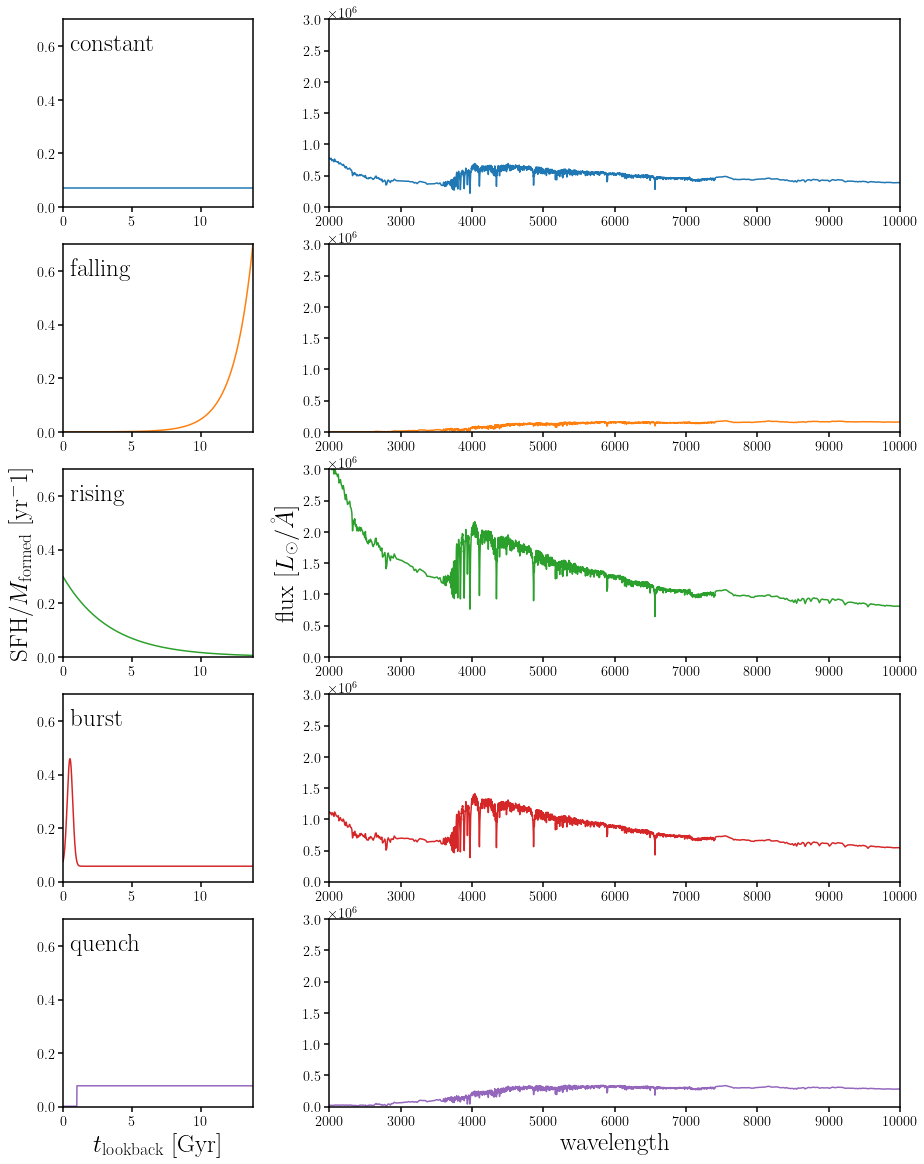

In [6]:
fig = plt.figure(figsize=(15,20))
gs = gridspec.GridSpec(5, 2, width_ratios=[1,3]) 
for i, sfh, sed, lbl in zip(range(5), sfhs, seds, lbls): 
    sub = plt.subplot(gs[i,0])
    sub.plot(tlb, sfh, c='C%i' % i, label=lbl)
    if i == 4: sub.set_xlabel(r'$t_{\rm lookback}$ [Gyr]', fontsize=25)
    sub.set_xlim(0, tage)
    if i == 2: sub.set_ylabel(r'SFH/$M_{\rm formed}$ [${\rm yr}^-1$]', fontsize=25)
    sub.set_ylim(0, 0.7)
    sub.text(0.5, 0.65, lbl, ha='left', va='top', fontsize=25)
    
    sub = plt.subplot(gs[i,1])
    sub.plot(wave, sed, c='C%i' % i, label=lbl)
    sub.set_xlim(2e3, 1e4)
    sub.set_ylim(0, 3e6)
    if i == 4: sub.set_xlabel('wavelength', fontsize=25)
    if i == 2: sub.set_ylabel(r'flux [$L_\odot/\AA$]', fontsize=25)

# run SED fitting on the mock data using a $\tau$-model SFH

In [7]:
m_tau = Models.Tau(burst=True, emulator=False)

$\tau$ SED model

In [8]:
def sed_tau(theta): 
    ''' SED for a tau model with a burst
    '''
    tau_sfh, sf_start, fburst, tburst = theta
    tt = np.array([10., tau_sfh, 0., sf_start, fburst, tburst, 0.0190, 0.3])
    return m_tau._fsps(tt, tage)

## define prior
Uniform priors on the 5 dimensions

In [9]:
prior = Infer.load_priors([
    Infer.UniformPrior(10., 10., label='sed'), 
    Infer.UniformPrior(0.1, 10., label='sed'), # tau_SFH
    Infer.UniformPrior(0., 0., label='sed'), # const sf
    Infer.UniformPrior(0., tage-1.0000001, label='sed'), # sf_start
    Infer.UniformPrior(0., 1., label='sed'), # fburst
    Infer.UniformPrior(0., tage, label='sed'), # tburst 
    Infer.UniformPrior(0.0190, 0.0190, label='sed'),# metallicity
    Infer.UniformPrior(0.3, 0.3, label='sed')      # uniform priors on dust2
])

CP_kde = Corrprior.CorrectPrior(
    m_tau, 
    prior, 
    zred=0.,
    props=['logavgssfr_1gyr'], 
    Nprior=100000, 
    method='kde',
    bandwidth=0.005,
    range=[(-13., -9.)],
    debug=True
)

... calculating log avg sSFR_1Gyr
... fitting prior(derived prop)
... fitting pdf using kde


In [10]:
theta_prior = np.array([prior.sample() for i in range(10000)])
logssfr_prior = CP_kde._get_properties(theta_prior)

(-13.0, -9.0)

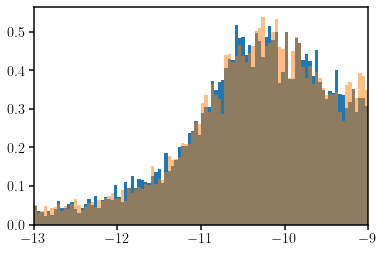

In [11]:
ftheta_priorhat = CP_kde.p_ftheta.sample(10000)

plt.hist(logssfr_prior, range=(-13, -9), bins=100, density=True)
plt.hist(ftheta_priorhat, range=(-13, -9), bins=100, density=True, alpha=0.5)
plt.xlim(-13., -9)

In [12]:
w_imp = CP_kde.get_importance_weights(theta_prior, outlier=0.1)

(-13.0, -9.0)

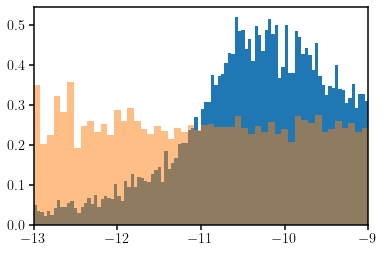

In [13]:
plt.hist(logssfr_prior, range=(-13, -9), bins=100, density=True)
plt.hist(logssfr_prior, weights=w_imp, range=(-13, -9), bins=50, density=True, alpha=0.5)
plt.xlim(-13., -9)

In [14]:
def lnPrior(theta):
    ''' uniform priors on tau, sf start, fburst, tburst
    '''
    tau_sfh, sf_start, fburst, tburst = theta
    tt = np.array([10., tau_sfh, 0., sf_start, fburst, tburst, 0.0190, 0.3])

    lp = prior.lnPrior(tt)
    if not np.isfinite(lp):
        return -np.inf 
    
    ftheta = CP_kde._get_properties(tt)
    lpf = CP_kde.p_ftheta.log_pdf(ftheta)[0]

    if not np.isfinite(lpf): 
        return -np.inf
    
    return lp - lpf

In [15]:
nwalkers, ndim = 20, 4
# initialize walkers
_start = np.array([prior.sample() for i in range(nwalkers)])
start = np.concatenate([np.atleast_2d(_start[:,1]).T, _start[:,3:6]], axis=1)
print(start)

# run MCMC chain
sampler_prior = emcee.EnsembleSampler(nwalkers, ndim, lnPrior)
_ = sampler_prior.run_mcmc(start, 10000)

[[6.07093259e+00 1.25887248e+01 2.97112387e-01 6.75694631e+00]
 [6.25902164e+00 1.23465392e+01 3.25387258e-01 7.74606355e+00]
 [6.11637813e+00 9.52332617e+00 2.73117838e-01 1.30850771e+01]
 [1.60477058e+00 6.14224476e+00 2.86522164e-01 9.57728506e+00]
 [5.95864180e+00 1.13339887e+01 3.06472796e-01 1.93060183e+00]
 [7.18761400e+00 3.83702118e+00 2.61719839e-01 9.76433726e+00]
 [8.62918473e+00 5.75968258e+00 3.86333400e-04 4.21386699e+00]
 [6.54346700e+00 2.62112342e+00 2.56862618e-01 2.76110572e+00]
 [8.70302253e+00 1.23055069e+00 8.04501131e-01 1.29620975e+01]
 [3.46254952e+00 2.30798279e+00 7.79055344e-01 8.48320546e+00]
 [9.48509902e+00 9.13288559e+00 4.79249658e-01 2.70818022e+00]
 [8.82045375e+00 3.86491888e+00 9.88966823e-01 1.20983111e+01]
 [3.46736650e+00 7.15653547e+00 2.16021392e-01 1.03278917e+01]
 [9.92666385e+00 3.74480565e+00 8.65582751e-01 7.08135889e+00]
 [7.80403375e+00 9.41066322e+00 7.82240856e-02 9.62150017e+00]
 [5.54469593e+00 1.11729534e+01 1.49185580e-01 1.271347

In [16]:
chain = sampler_prior.get_chain(flat=True)
logssfr_chain = CP_kde._get_properties(np.array([
    np.repeat(10, chain.shape[0]), 
    chain[:,0], 
    np.repeat(0, chain.shape[0]), 
    chain[:,1], 
    chain[:,2], 
    chain[:,3], 
    np.repeat(0.0190, chain.shape[0]), 
    np.repeat(0.3, chain.shape[0])]).T)

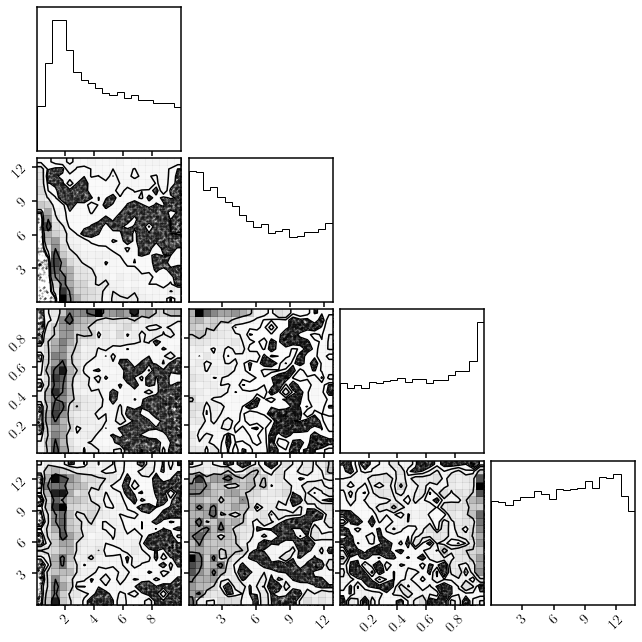

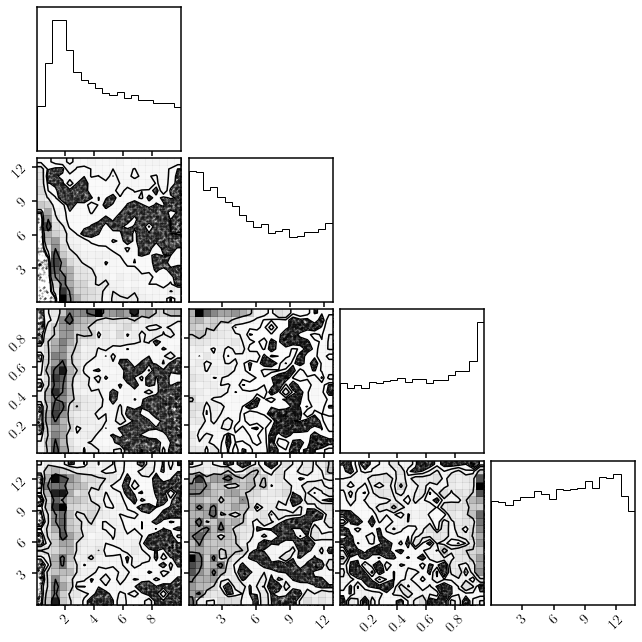

In [17]:
DFM.corner(chain)

(-13.0, -9.0)

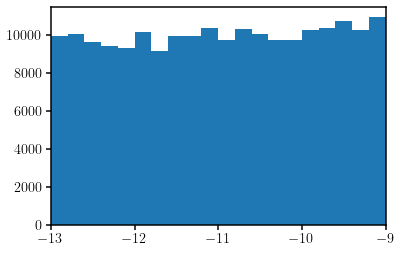

In [18]:
plt.hist(logssfr_chain, range=(-13., -9), bins=20)
plt.xlim(-13., -9)

## define likelihood and posterior
simple chi-squared likelihood

In [19]:
wlim = (wave > 2e3) & (wave < 1e4) # wavelength limit for convenience

def lnLike(theta, flux_obs, ivar_obs): 
    '''
    '''
    # get tau model SED
    w, flux_model = sed_tau(theta)
    
    # calculate chi2
    chi2 = np.sum((flux_obs - flux_model[wlim])**2 * ivar_obs)
    
    return -0.5 * chi2

def lnPost(theta, flux_obs, ivar_obs): 
    '''
    '''
    lp = lnPrior(theta)

    if not np.isfinite(lp): 
        return -np.inf
    
    lnlike = lnLike(theta, flux_obs, ivar_obs)
    
    return lp + lnlike

In [21]:
nwalkers, ndim = 20, 4

samplers = []
for i, sed in enumerate(seds): 
    # initialize walkers
    _lnpost = lambda *args: -2. * lnPost(*args)
    min_result = op.minimize(
        _lnpost, 
        np.array([1., 0.9*tage, 0.1, 0.5*tage]), 
        args=(sed[wlim], np.ones(np.sum(wlim))))
    tt0 = min_result['x'] 
    logp0 = -0.5*min_result['fun']
    start = [tt0 + 1e-3 * np.random.randn(4) for i in range(nwalkers)]
    
    # run MCMC chain
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnPost, args=(sed[wlim], np.ones(np.sum(wlim))))
    sampler.run_mcmc(start, 10000)
    samplers.append(sampler)

In [22]:
# save the chains
for sampler, lbl in zip(samplers, lbls): 
    chain = sampler.get_chain()
    np.save('/Users/chahah/data/provabgs/prior_correct/mcmc.%s.priorcorr.npy' % lbl, chain)

In [27]:
nwalkers, ndim = 20, 4
chains = [] 
# save the chains
for lbl in lbls:
    chains.append(np.load('/Users/chahah/data/provabgs/prior_correct/mcmc.%s.priorcorr.npy' % lbl))

In [28]:
def SFH(theta): 
    ''' tau star formation history for given parameter values.
    '''
    from scipy.special import gammainc
    tau_sfh, sf_start, fburst, tburst = theta
    
    # tau or delayed-tau 
    power = 1 

    t = np.linspace(sf_start, tage, 1000)
    tlookback = t - sf_start
    dt = np.diff(t)[0]
    dts = np.repeat(dt, 1000)
    dts[0] *= 0.5
    dts[-1] *= 0.5

    tmax = (tage - sf_start) / tau_sfh
    normalized_t = (t - sf_start)/tau_sfh

    # constant contribution 
    sfh = np.zeros(1000)

    # burst contribution 
    tb = (tburst - sf_start) / tau_sfh
    if tb > 0 and fburst > 0: 
        iburst = np.floor(tb / dt * tau_sfh).astype(int)
        sfh[iburst] += fburst / dts[iburst]

    # tau contribution 
    ftau = (1.  - fburst) 
    sfh_tau = (normalized_t **(power - 1) * np.exp(-normalized_t))
    sfh += sfh_tau * (ftau / tau_sfh / np.trapz(sfh_tau, normalized_t))
    return tlookback, sfh 

[10.          7.80942625  0.49290782  2.57610622]
[ 1.91935134 11.69323077  0.99985436  1.63527769]
[10.         12.79629066  0.73628416 10.65659026]
[ 0.36624339 12.79629066  0.61176729  2.55222486]
[ 0.36837904 11.60471346  0.83835349  6.30829182]


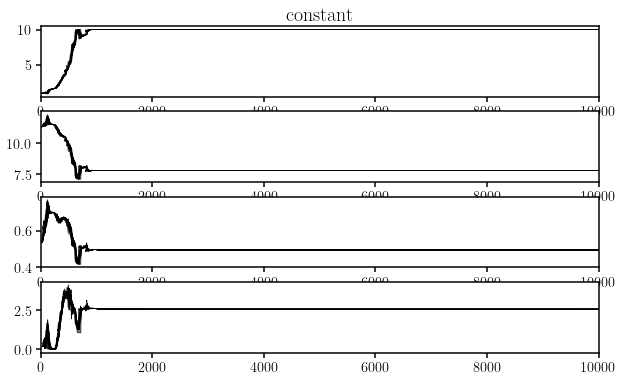

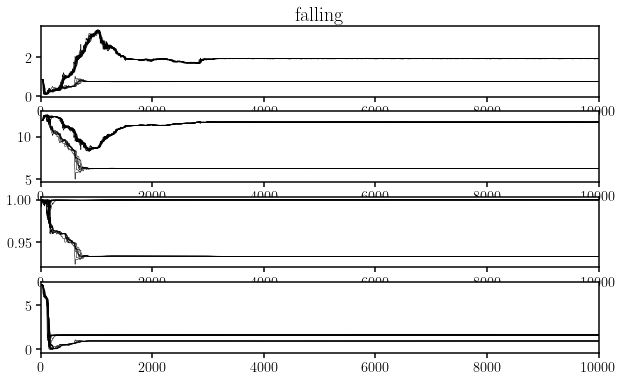

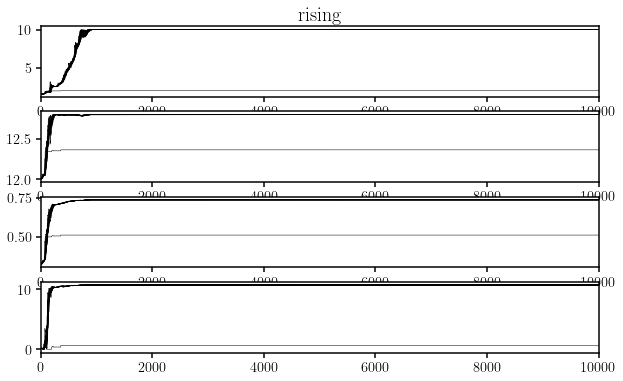

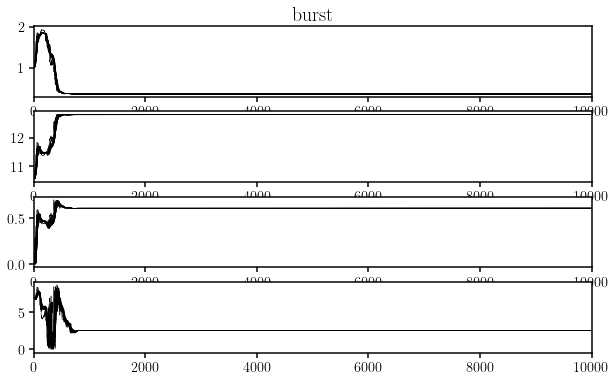

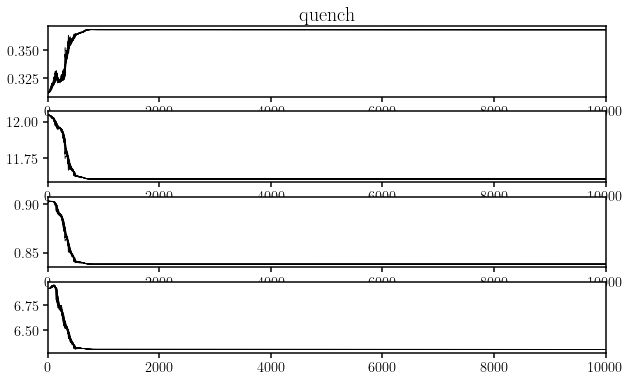

In [29]:
fluxes_bestfit, sfhs_bestfit, sfhs_chain = [], [], [] 
for chain, lbl in zip(chains, lbls): 
    fig = plt.figure(figsize=(10, 6))
    for ii in range(4): 
        sub = fig.add_subplot(4, 1, ii+1)
        for j in range(nwalkers): 
            sub.plot(chain[:,j,ii], c='k', lw=0.5)
        sub.set_xlim(0,10000)
        if ii == 0: sub.set_title(lbl, fontsize=20)
    
    s = list(chain.shape[1:])
    s[0] = np.prod(chain.shape[:2]) 
    flat_chain = chain.reshape(s)
    theta_median = np.median(flat_chain[40000:,:], axis=0)
    # calculate bestfit SED
    _, flux_bestfit = sed_tau(theta_median)
    print(theta_median)
    # calculate bestfit SFH
    sfh_bestfit = SFH(theta_median)
    
    sfh_chain = [SFH(theta_i) for theta_i in flat_chain[np.random.choice(range(4000, flat_chain.shape[0]), 1000, replace=False)]]
    
    fluxes_bestfit.append(flux_bestfit)
    sfhs_bestfit.append(sfh_bestfit)
    sfhs_chain.append(sfh_chain)

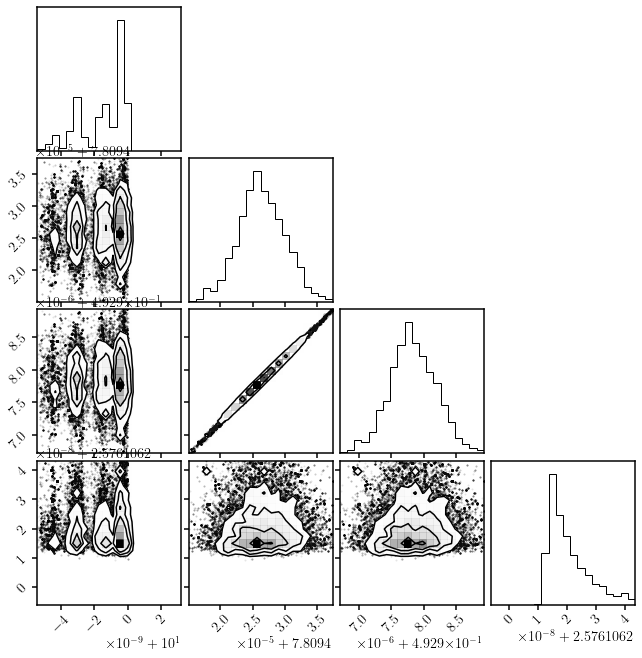

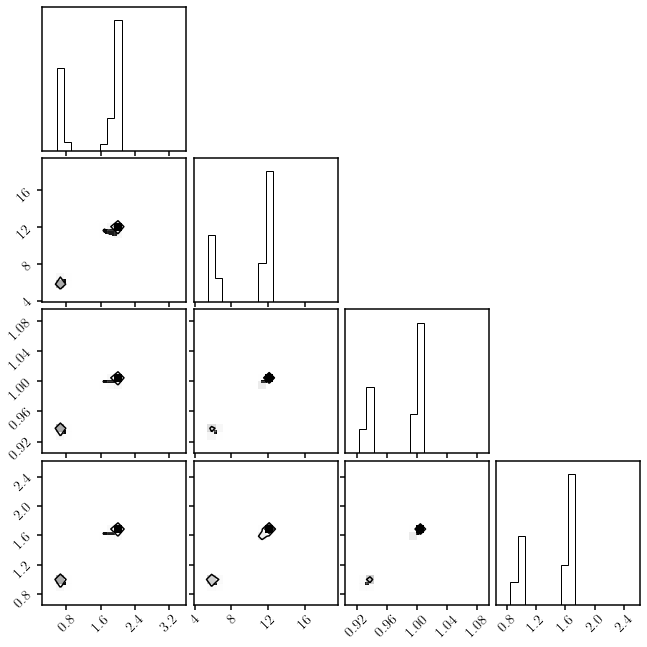

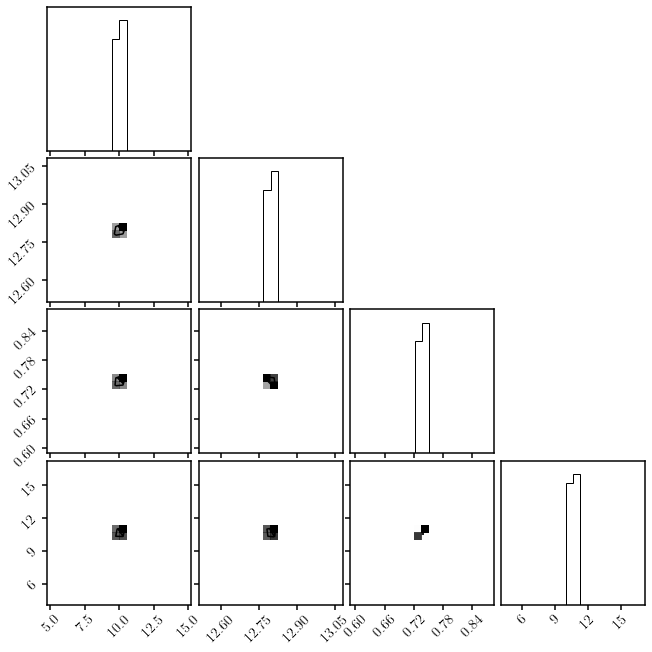

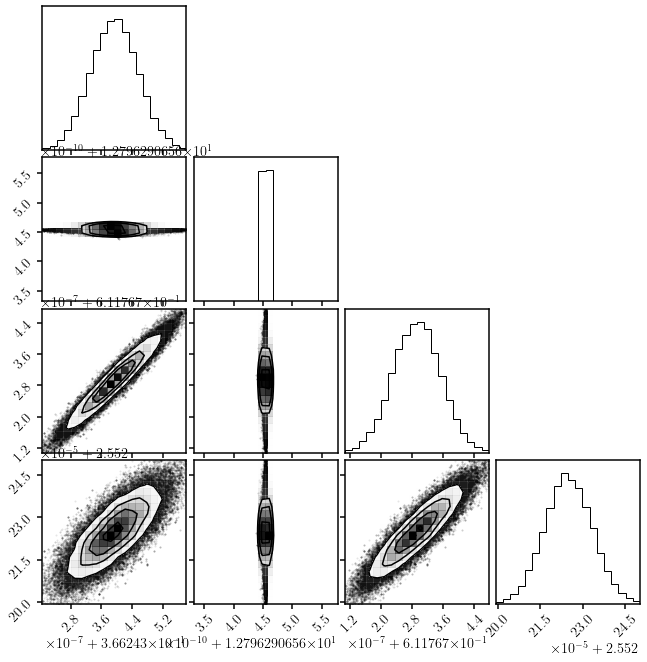

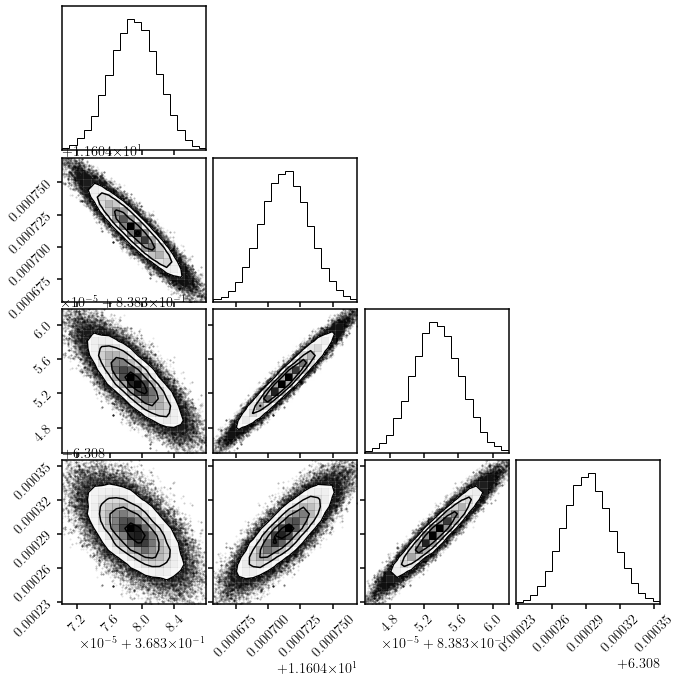

In [25]:
for sampler, lbl in zip(samplers, lbls): 
    flat_chain = sampler.get_chain(flat=True)
    theta_median = np.median(flat_chain[40000:,:], axis=0)
    std_median = np.std(flat_chain[40000:,:], axis=0)
    fig = DFM.corner(flat_chain[40000:,:], range=[(l, h) for l, h in zip(theta_median - 3*std_median, theta_median + 3*std_median)])

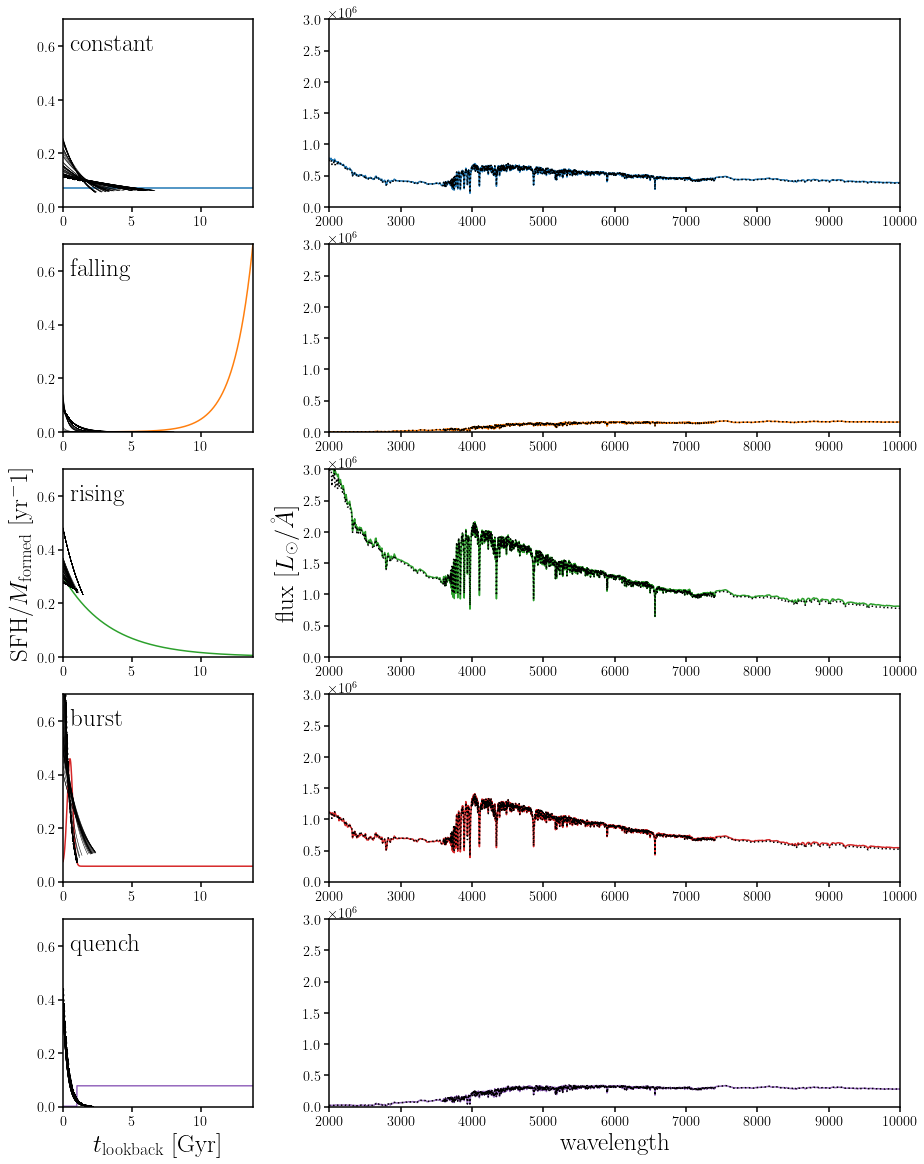

In [30]:
fig = plt.figure(figsize=(15,20))
gs = gridspec.GridSpec(5, 2, width_ratios=[1,3]) 
for i, sfh, sed, sfh_bf, flux_bf, lbl in zip(range(5), sfhs, seds, sfhs_bestfit, fluxes_bestfit, lbls): 
    sub = plt.subplot(gs[i,0])
    sub.plot(tlb, sfh, c='C%i' % i, label=lbl)
    sub.plot(sfh_bf[0], sfh_bf[1], c='k', ls=':', lw=2)
    for ii in range(1000): 
        sub.plot(sfhs_chain[i][ii][0], sfhs_chain[i][ii][1], c='k', ls='-', lw=0.5)
    if i == 4: sub.set_xlabel(r'$t_{\rm lookback}$ [Gyr]', fontsize=25)
    sub.set_xlim(0, tage)
    if i == 2: sub.set_ylabel(r'SFH/$M_{\rm formed}$ [${\rm yr}^-1$]', fontsize=25)
    sub.set_ylim(0, 0.7)
    sub.text(0.5, 0.65, lbl, ha='left', va='top', fontsize=25)
    
    sub = plt.subplot(gs[i,1])
    sub.plot(wave, sed, c='C%i' % i, label=lbl)
    sub.plot(wave, flux_bf, c='k', ls=':')
    sub.set_xlim(2e3, 1e4)
    sub.set_ylim(0, 3e6)
    if i == 4: sub.set_xlabel('wavelength', fontsize=25)
    if i == 2: sub.set_ylabel(r'flux [$L_\odot/\AA$]', fontsize=25)

In [31]:
logssfr_chains = []
for chain, lbl in zip(chains, lbls): 
    s = list(chain.shape[1:])
    s[0] = np.prod(chain.shape[:2]) 
    flat_chain = chain.reshape(s)
    
    logssfr_chain = CP_kde._get_properties(np.array([
        np.repeat(10, flat_chain.shape[0]), 
        flat_chain[:,0], 
        np.repeat(0, flat_chain.shape[0]), 
        flat_chain[:,1], 
        flat_chain[:,2], 
        flat_chain[:,3], 
        np.repeat(0.0190, flat_chain.shape[0]), 
        np.repeat(0.3, flat_chain.shape[0])]).T)
    logssfr_chains.append(logssfr_chain)

In [32]:
from scipy.integrate import quad
from scipy.interpolate import interp1d

In [33]:
avg_logssfr_true = []
for sfh in sfhs: 
    f_sfh = interp1d(tlb, sfh)
    sfr, _ = quad(f_sfh, 0., 1.)
    avg_logssfr_true.append(np.log10(sfr/1e9))

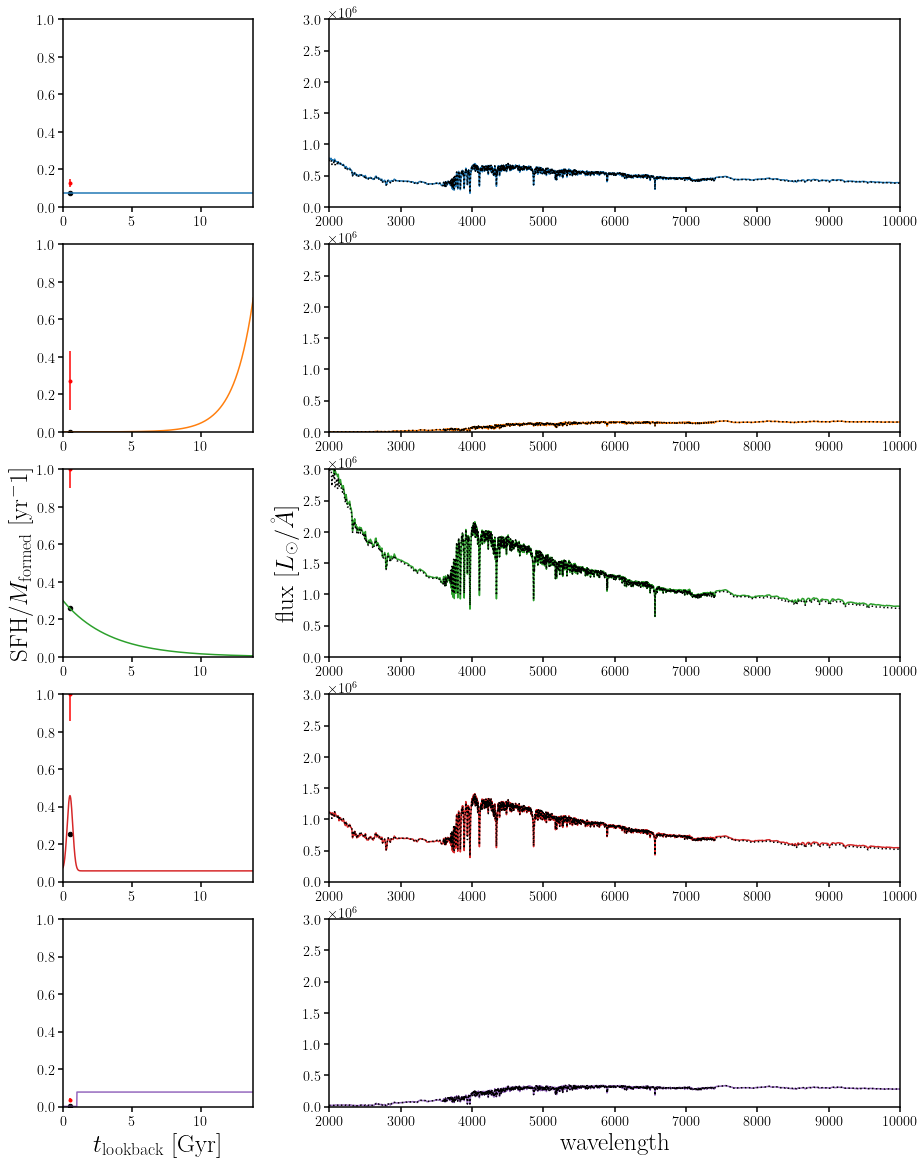

In [44]:
fig = plt.figure(figsize=(15,20))
gs = gridspec.GridSpec(5, 2, width_ratios=[1,3]) 
for i, sfh, sed, sfh_bf, flux_bf, lbl in zip(range(5), sfhs, seds, sfhs_bestfit, fluxes_bestfit, lbls): 
    sub = plt.subplot(gs[i,0])
    sub.plot(tlb, sfh, c='C%i' % i, label=lbl)
    sub.scatter([0.5], 10**(avg_logssfr_true[i]+9), c='k', s=20)
    sub.errorbar([0.5], 10**(np.median(logssfr_chains[i])+9), yerr=np.std(10**(logssfr_chains[i]+9)), fmt='.r')
    
    if i == 4: sub.set_xlabel(r'$t_{\rm lookback}$ [Gyr]', fontsize=25)
    sub.set_xlim(0, tage)
    if i == 2: sub.set_ylabel(r'SFH/$M_{\rm formed}$ [${\rm yr}^-1$]', fontsize=25)
    sub.set_ylim(0, 1.)
    
    sub = plt.subplot(gs[i,1])
    sub.plot(wave, sed, c='C%i' % i, label=lbl)
    sub.plot(wave, flux_bf, c='k', ls=':')
    sub.set_xlim(2e3, 1e4)
    sub.set_ylim(0, 3e6)
    if i == 4: sub.set_xlabel('wavelength', fontsize=25)
    if i == 2: sub.set_ylabel(r'flux [$L_\odot/\AA$]', fontsize=25)